In [2]:
# cài đặt thư viện d2l
!pip install d2l==0.16.5

     |████████████████████████████████| 77 kB 3.2 MB/s 


# Gated Recurrent Units (GRU)

- Trong phần trước, chúng ta đã thảo luận cách tính gradient trong mạng nơ-ron hồi tiếp. Cụ thể ta đã biết rằng tích của một chuỗi dài các ma trận có thể dẫn đến việc gradient tiêu biến hoặc bùng nổ. Hãy điểm qua các tình huống thực tế thể hiện rõ hai bất thường đó:

 - Ta có thể gặp tình huống mà những quan sát xuất hiện sớm có ảnh hưởng lớn đến việc dự đoán toàn bộ những quan sát trong tương lai. Xét một ví dụ có chút cường điệu, trong đó quan sát đầu tiên chứa giá trị tổng kiểm (checksum) và mục tiêu là kiểm tra xem liệu giá trị tổng kiểm đó có đúng hay không tại cuối chuỗi. Trong trường hợp này, ảnh hưởng của token đầu tiên là tối quan trọng. Do đó ta muốn có cơ chế để lưu trữ những thông tin quan trọng ban đầu trong ô nhớ. Nếu không, ta sẽ phải gán một giá trị gradient cực lớn cho quan sát ban đầu vì nó ảnh hưởng đến toàn bộ các quan sát tiếp theo.
- Một tình huống khác là khi một vài ký hiệu không chứa thông tin phù hợp. Ví dụ, khi phân tích một trang web, ta có thể gặp các mã HTML không giúp ích gì cho việc xác định thông tin được truyền tải. Do đó, ta cũng muốn có cơ chế để bỏ qua những ký hiệu như vậy trong các biểu diễn trạng thái tiềm ẩn.
- Ta cũng có thể gặp những khoảng ngắt giữa các phần trong một chuỗi. Ví dụ như những phần chuyển tiếp giữa các chương của một quyển sách, hay chuyển biến xu hướng giữa thị trường giá lên và thị trường giá xuống trong chứng khoán. Trong trường hợp này, sẽ tốt hơn nếu có một cách để xóa hay đặt lại các biểu diễn trạng thái ẩn về giá trị ban đầu

Nhiều phương pháp đã được đề xuất để giải quyết những vấn đề trên. Một trong những phương pháp ra đời sớm nhất là Bộ nhớ ngắn hạn dài (Long Short Term Memory - LSTM) :cite:`Hochreiter.Schmidhuber.1997` and The gated recurrent unit (GRU)
:cite:`Cho.Van-Merrienboer.Bahdanau.ea.2014` là một biến thể gọn hơn của LSTM, thường có chất lượng tương đương và tính toán nhanh hơn đáng kể
. Trong bài này, ta sẽ bắt đầu với GRU do nó đơn giản hơn.

## Gated Hidden State

Sự khác biệt chính giữa RNN thông thường và GRU là GRU hỗ trợ việc kiểm soát trạng thái ẩn. Điều này có nghĩa là ta có các cơ chế được học để quyết định khi nào nên cập nhật và khi nào nên xóa trạng thái ẩn. Ví dụ, nếu ký tự đầu tiên có mức độ quan trọng cao, mô hình sẽ học để không cập nhật trạng thái ẩn sau lần quan sát đầu tiên. Tương tự, mô hình sẽ học cách bỏ qua những quan sát tạm thời không liên quan, cũng như cách xóa trạng thái ẩn khi cần thiết. Dưới đây ta sẽ thảo luận chi tiết vấn đề này.


### Reset Gate and Update Gate

Đầu tiên ta giới thiệu cổng xóa và cổng cập nhật. Ta thiết kế chúng thành các vector có các phần tử trong khoảng  (0,1)  để có thể biểu diễn các tổ hợp lồi. Chẳng hạn, một biến xóa cho phép kiểm soát bao nhiêu phần của trạng thái trước đây được giữ lại. Tương tự, một biến cập nhật cho phép kiểm soát bao nhiêu phần của trạng thái mới sẽ giống trạng thái cũ.

Ta bắt đầu bằng việc thiết kế các cổng tạo ra các biến này. :numref:`fig_gru_1` minh họa các đầu vào cho cả cổng xóa và cổng cập nhật trong GRU, với đầu vào ở bước thời gian hiện tại  $X_t$  và trạng thái ẩn ở bước thời gian trước đó $\mathbf{H}_{t-1}$ . Đầu ra được tạo bởi một tầng kết nối đầy đủ với hàm kích hoạt sigmoid.

![Computing the reset gate and the update gate in a GRU model.](https://github.com/d2l-ai/d2l-tensorflow-colab/blob/master/img/gru-1.svg?raw=1)
:label:`fig_gru_1`

Tại bước thời gian  t , với đầu vào minibatch là
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$ (số lượng mẫu:  n , số lượng đầu vào:  d) và trạng thái ẩn ở bước thời gian gần nhất là $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$ (số lượng trạng thái ẩn:  h). Cổng xóa $\mathbf{R}_t \in \mathbb{R}^{n \times h}$ và cổng cập nhật $\mathbf{Z}_t \in \mathbb{R}^{n \times h}$ được tính như sau: 

$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{aligned}
$$

với $\mathbf{W}_{xr}, \mathbf{W}_{xz} \in \mathbb{R}^{d \times h}$ và
$\mathbf{W}_{hr}, \mathbf{W}_{hz} \in \mathbb{R}^{h \times h}$ là các tham số trọng số và $\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$ là các hệ số điều chỉnh. Ta sẽ sử dụng hàm sigmoid để biến đổi các giá trị đầu vào nằm trong khoảng  (0,1) .

#### Reset gate

Ta bắt đầu bằng việc tích hợp cổng xóa với một cơ chế cập nhật trạng thái tiềm ẩn thông thường. Trong RNN thông thường, ta cập nhật trạng thái ẩn theo công thức:
$$\mathbf{H}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1}\mathbf{W}_{hh} + \mathbf{b}_h).$$

Điều này về cơ bản giống với những gì đã thảo luận ở phần trước, mặc dù có thêm tính phi tuyến dưới dạng hàm  tanh  để đảm bảo rằng các giá trị trạng thái ẩn nằm trong khoảng  (−1,1) . Nếu muốn giảm ảnh hưởng của các trạng thái trước đó, ta có thể nhân  $\mathbf{H}_{t-1}$   với  $R_t$  theo từng phần tử. Nếu các phần tử trong cổng xóa  $R_t$  có giá trị gần với  1 , kết quả sẽ giống RNN thông thường. Nếu tất cả các phần tử của cổng xóa  Rt  gần với  0 , trạng thái ẩn sẽ là đầu ra của một perceptron đa tầng với đầu vào là  $X_t$ . Bất kỳ trạng thái ẩn nào tồn tại trước đó đều được đặt lại về giá trị mặc định. Tại đây nó được gọi là trạng thái ẩn tiềm năng, và chỉ là tiềm năng vì ta vẫn cần kết hợp thêm đầu ra của cổng cập nhật.

$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h).$$


Hình sau minh họa luồng tính toán sau khi áp dụng cổng xóa. Ký hiệu  ⊙  biểu thị phép nhân theo từng phần tử giữa các tensor

![](https://d2l.aivivn.com/_images/gru_2.svg)

#### Update gate

Tiếp theo ta sẽ kết hợp hiệu ứng của cổng cập nhật  $Z_t$  như trong hình dưới. Cổng này xác định mức độ giống nhau giữa trạng thái mới  $H_t$  và trạng thái cũ  $\mathbf{H}_{t-1}$ , cũng như mức độ trạng thái ẩn tiềm năng  $\tilde{\mathbf{H}}_t$  được sử dụng. Biến cổng (gating variable)  $Z_t$  được sử dụng cho mục đích này, bằng cách áp dụng tổ hợp lồi giữa trạng thái cũ và trạng thái tiềm năng. Ta có phương trình cập nhật cuối cùng cho GRU.

$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.$$

Nếu các giá trị trong cổng cập nhật  $Z_t$  bằng  1 , chúng ta chỉ đơn giản giữ lại trạng thái cũ. Trong trường hợp này, thông tin từ  $X_t$  về cơ bản được bỏ qua, tương đương với việc bỏ qua bước thời gian  $t$  trong chuỗi phụ thuộc. Ngược lại, nếu  $Z_t$  gần giá trị  0 , trạng thái ẩn  Ht  sẽ gần với trạng thái ẩn tiềm năng  $\tilde{\mathbf{H}}_t$ . Những thiết kế trên có thể giúp chúng ta giải quyết vấn đề tiêu biến gradient trong các mạng RNN và nắm bắt tốt hơn sự phụ thuộc xa trong chuỗi thời gian. Tóm lại, các mạng GRU có hai tính chất nổi bật sau:

- Cổng xóa giúp nắm bắt các phụ thuộc ngắn hạn trong chuỗi thời gian.
- Cổng cập nhật giúp nắm bắt các phụ thuộc dài hạn trong chuỗi thời gian.





## Implementation from Scratch

Để hiểu rõ hơn, hãy lập trình mô hình GRU từ đầu.


In [3]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### Initializing Model Parameters

Bước tiếp theo là khởi tạo các tham số mô hình. Ta khởi tạo các giá trị trọng số theo phân phối Gauss với phương sai  0.01  và thiết lập các hệ số điều chỉnh bằng  0 . Siêu tham số `num_hiddens` xác định số lượng đơn vị ẩn. Ta khởi tạo tất cả các trọng số và các hệ số điều chỉnh của cổng cập nhật, cổng xóa, và các trạng thái ẩn tiềm năng. Sau đó, gắn gradient cho tất cả các tham số.


In [4]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # Update gate parameters
    W_xr, W_hr, b_r = three()  # Reset gate parameters
    W_xh, W_hh, b_h = three()  # Candidate hidden state parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### Defining the Model

Bây giờ ta sẽ định nghĩa hàm khởi tạo trạng thái ẩn init_gru_state. Hàm này trả về một mảng ndarray chứa các giá trị bằng không với kích thước (kích thước batch, số đơn vị ẩn).


In [6]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

Giờ ta có thể định nghĩa mô hình GRU. Cấu trúc GRU cũng giống một khối RNN cơ bản nhưng có phương trình cập nhật phức tạp hơn.

In [7]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R*H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

### Training and Prediction

Việc huấn luyện và dự đoán cũng được thực hiện tương tự như với RNN. Sau khi huấn luyện một epoch, ta thu được perplexity và câu đầu ra như sau.

perplexity 1.1, 15591.7 tokens/sec on cuda:0
time traveller with a slight accession ofcheerfulness really thi
travelleryou can show black is white by argument said filby


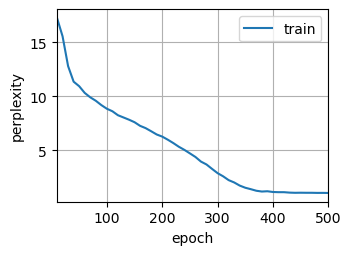

In [9]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
def use_svg_display_dummy():
    pass
d2l.use_svg_display = use_svg_display_dummy
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Concise Implementation

Trong Gluon, ta có thể trực tiếp gọi lớp GRU trong mô-đun rnn. Mô-đun này đóng gói tất cả các cấu hình đã thực hiện tường minh ở trên. Đoạn mã này nhanh hơn đáng kể do sử dụng các toán tử được biên dịch chứ không phải thuần Python như trên.


perplexity 1.0, 169273.7 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


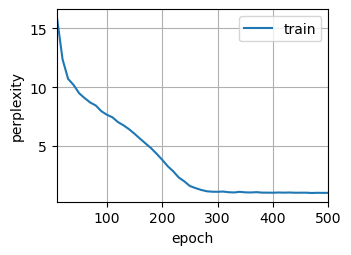

In [10]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Summary

- Các mạng nơ-ron hồi tiếp có cổng nắm bắt các phụ thuộc xa trong chuỗi thời gian tốt hơn.
- Cổng xóa giúp nắm bắt phụ thuộc ngắn hạn trong chuỗi thời gian.
- Cổng cập nhật giúp nắm bắt các phụ thuộc dài hạn trong chuỗi thời gian.
- Trường hợp đặc biệt khi cổng xóa được kích hoạt, GRU trở thành RNN cơ bản. - - Chúng cũng có thể bỏ qua các các thành phần trong chuỗi khi cần.


## Exercises

- Hãy so sánh thời gian chạy, perplexity và các chuỗi đầu ra của rnn.RNN và rnn.GRU.
- Quan sát và phân tích tác động tới thời gian chạy, perplexity và các câu được sinh ra khi điều chỉnh các siêu tham số.


### RNN model 

perplexity 1.6, 342557.6 tokens/sec on cuda:0
time traveller pat ingedman scallas id they in that alithere tha
travellery of castion anothen htine four uimension there in


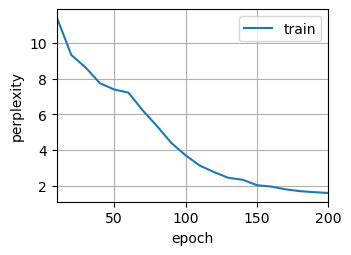

In [12]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs = 200
lr = 1
num_inputs = vocab_size
rnn_layer = nn.RNN(num_inputs, num_hiddens)
rnn_model = d2l.RNNModel(rnn_layer, vocab_size)
rnn_model = rnn_model.to(device)
d2l.train_ch8(rnn_model, train_iter,vocab,lr,num_epochs, device)

### GRU model

perplexity 3.6, 316564.6 tokens/sec on cuda:0
time traveller three dimensions and have a cently in and the tim
traveller three dimensions and have a cently in and the tim


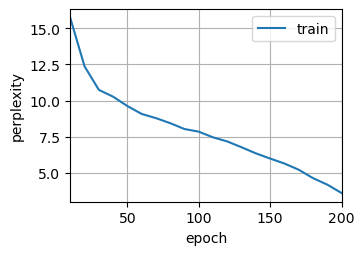

In [14]:
gru_layer = nn.GRU(num_inputs, num_hiddens)
gru_model = d2l.RNNModel(gru_layer, vocab_size).to(device)
d2l.train_ch8(gru_model, train_iter,vocab,lr,num_epochs, device)

### Changing model on GRU model


perplexity 1.0, 354173.2 tokens/sec on cuda:0
time traveller with a slight accession ofcheerfulness really thi
traveller with a slight accession ofcheerfulness really thi


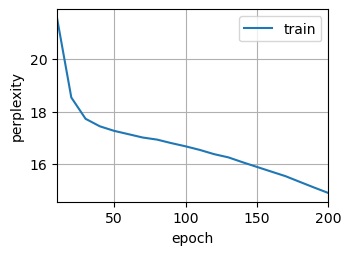

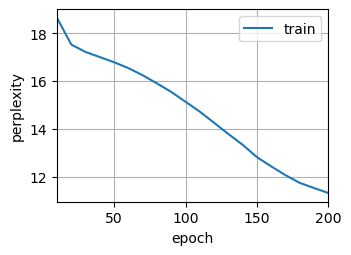

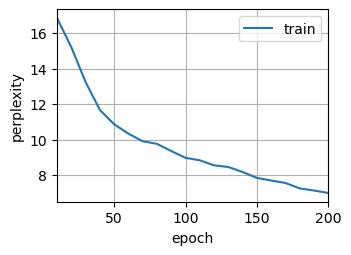

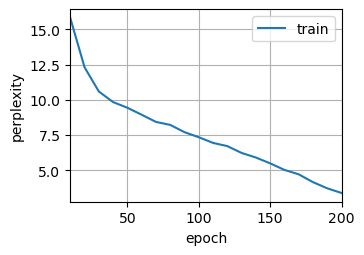

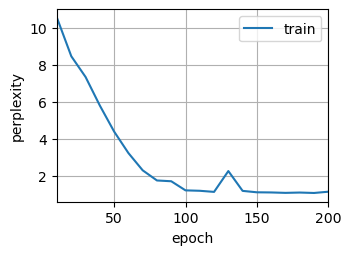

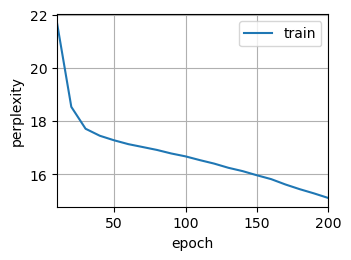

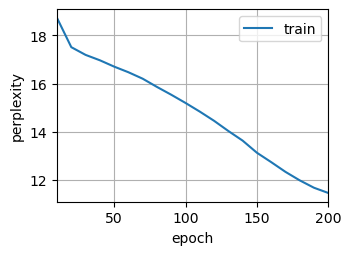

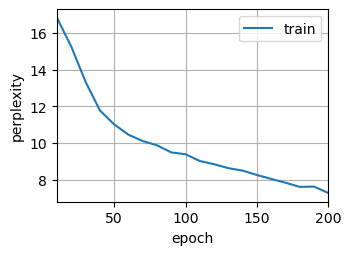

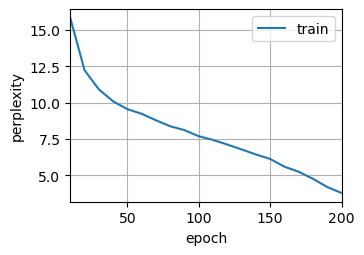

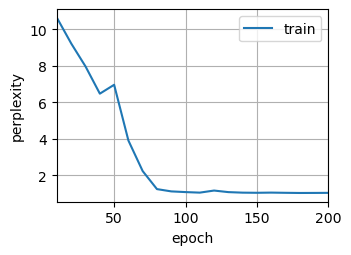

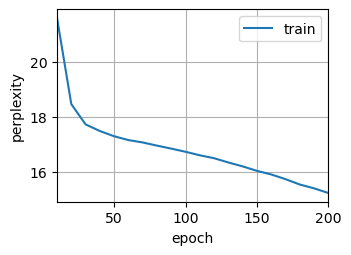

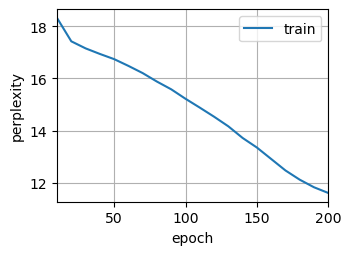

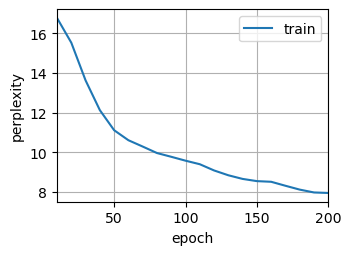

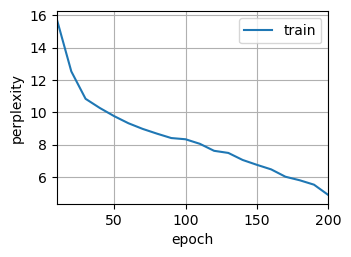

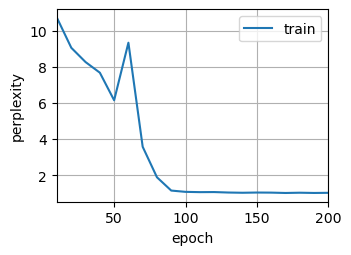

In [ ]:
vocab_size = len(vocab)
device = d2l.try_gpu()
lrs = [0.05, 0.1, 0.5, 1.0, 5.0]
num_hiddens = [128, 256, 512]
for num_hidden in num_hiddens:
    for lr in lrs:
        gru_layer = nn.GRU(num_inputs, num_hidden)
        gru_model = d2l.RNNModel(gru_layer, vocab_size).to(device)
        d2l.train_ch8(gru_model, train_iter, vocab, lr, num_epochs, device)